# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           plot_parameter_sensitivity,
                           plot_parameters_kde)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [5]:
from channels.ical import ical as model
#model.sample({})

# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [60]:
limits = dict(g_CaL=(0, 0.001),
              p1=(-50, 50),
              p2=(0, 100),
              p3=(-100, 100),
              p4=(-100, 100),
              p5=(-100, 100),
              p6=(-100, 100),
              p7=(0, 1000),
              p8=(0, 1000),
              q1=(0, 100),
              q2=(-100, 100),
              q3=(0, 10000),
              q4=(0, 200),
              q5=(-1000, 1000),
              q6=(0, 1000),
              q7=(0, 100),
              q8=(0, 100),
              q9=(-1000,1000))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [61]:
parameters = ['ical.'+k for k in limits.keys()]

# Test parameter sensitivity

In [30]:
sns.set_context('talk')

In [31]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

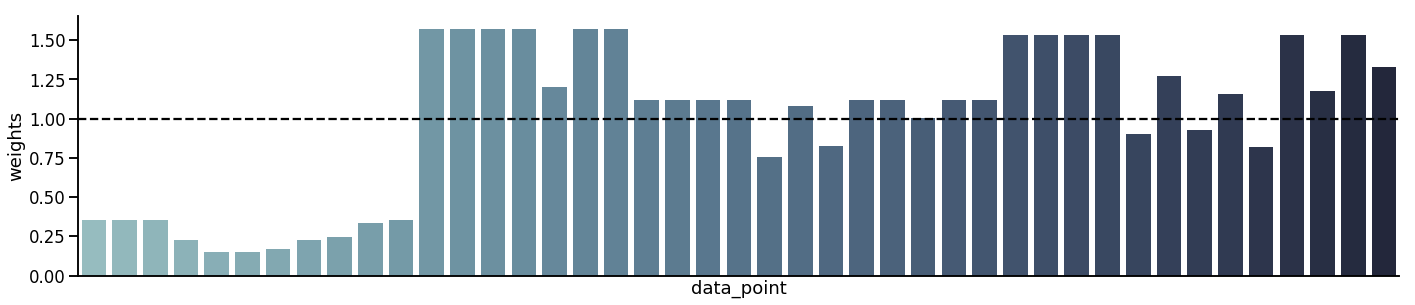

In [32]:
from ionchannelABC import plot_distance_weights
grid = plot_distance_weights(model, distance_fn)
grid.savefig('results/ical/dist_weights.pdf')

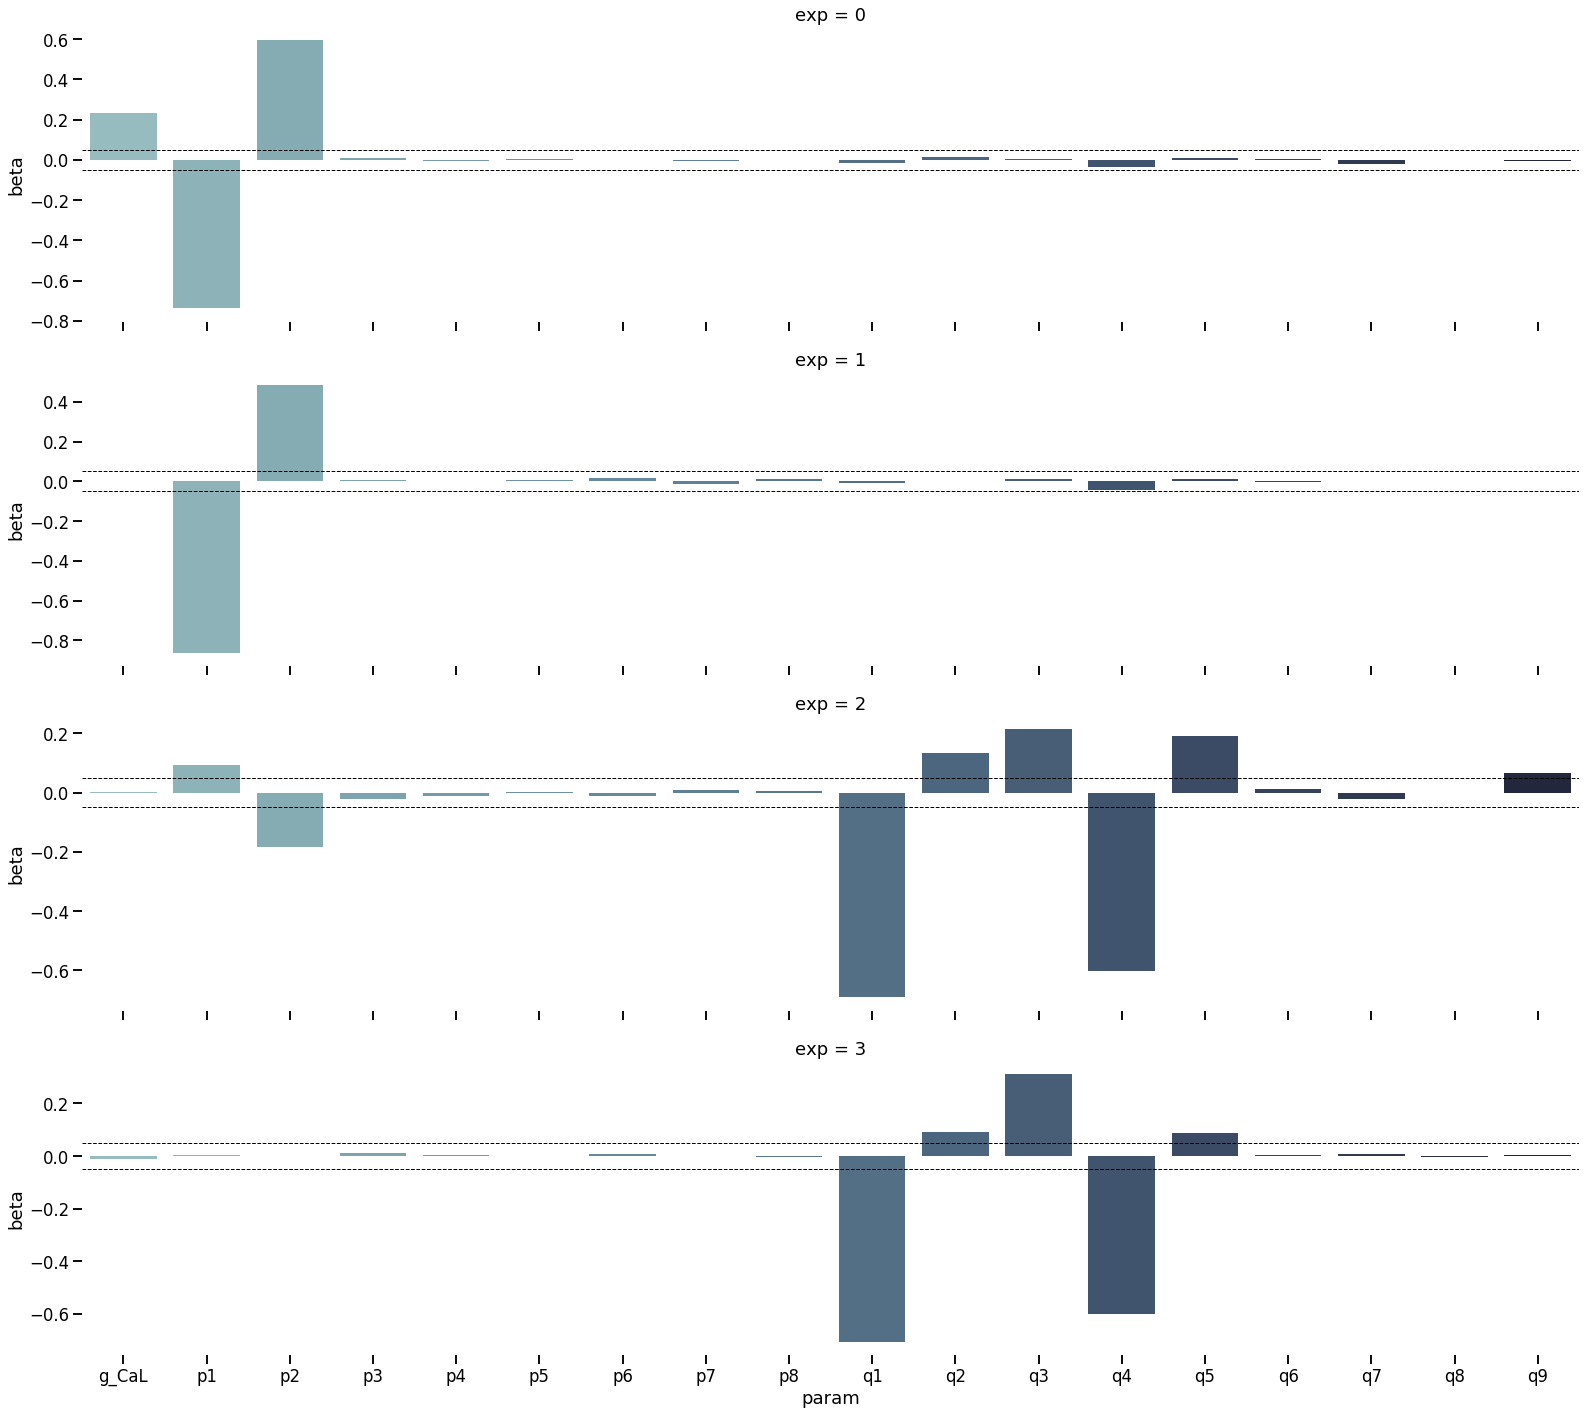

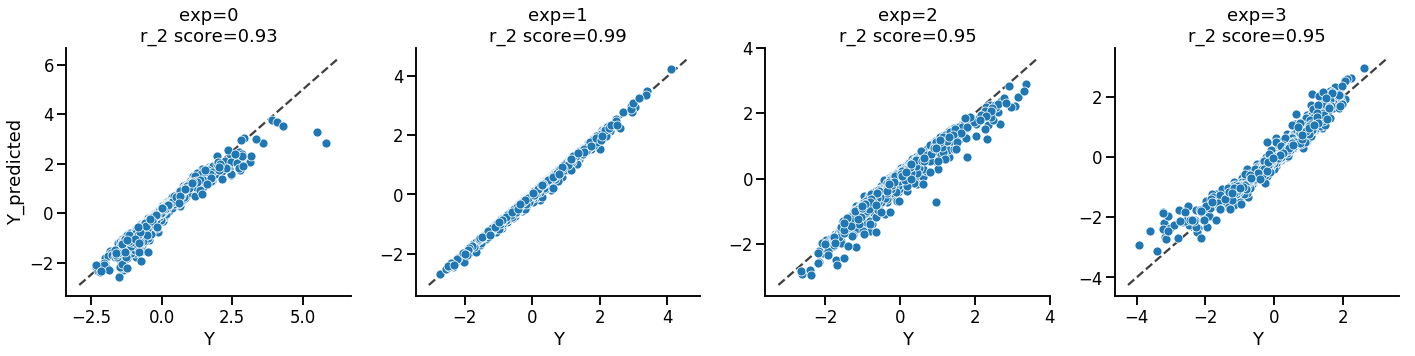

In [33]:
grid1, grid2 = plot_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=1000,
    plot_cutoff=0.05)

In [34]:
grid1.savefig('results/ical/sensitivity.pdf')
grid2.savefig('results/ical/sensitivity_fit.pdf')

In [13]:
# New limits eliminating insensitive parameters
limits = dict(g_CaL=(0, 0.001),
              p1=(-50, 50),
              p2=(0, 100),
              q1=(0, 100),
              q2=(-100, 100),
              q3=(0, 10000),
              q4=(0, 200),
              q5=(-1000, 1000),
              q9=(-1000,1000))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Initialise pyabc database

In [14]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ical.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ical.db


In [15]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [16]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=5000,
                 mean_cv=0.4,
                 max_population_size=5000,
                 min_population_size=1000),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.35660656938246293, 1: 0.35660656938246293, 2: 0.35660656938246293, 3: 0.2235508569788746, 4: 0.14818305191086062, 5: 0.14818305191086062, 6: 0.16990123682780803, 7: 0.22754257892652202, 8: 0.24501057926385836, 9: 0.3352837664439712, 10: 0.35660656938246293, 11: 1.574893351215255, 12: 1.574893351215255, 13: 1.574893351215255, 14: 1.574893351215255, 15: 1.1991074553643941, 16: 1.574893351215255, 17: 1.574893351215255, 18: 1.1217956589353755, 19: 1.1217956589353755, 20: 1.1217956589353755, 21: 1.1217956589353755, 22: 0.7585517117689706, 23: 1.0822285804786025, 24: 0.8281937231104962, 25: 1.1217956589353755, 26: 1.1217956589353755, 27: 1.0020504889481259, 28: 1.1217956589353755, 29: 1.1217956589353755, 30: 1.5324625057607502, 31: 1.5324625057607502, 32: 1.5324625057607502, 33: 1.5324625057607502, 34: 0.9039307823835155, 35: 1.2728821221318876, 36: 0.930913790812873, 37: 1.1550226663789356, 38: 0.8206739997955603, 39: 1.5324625057607502, 40: 1.1768155468

In [17]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=4, start_time=2018-09-11 16:14:42.616485, end_time=None)>
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
INFO:Epsilon:initial epsilon is 80.92415980390373


In [18]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=20, min_acceptance_rate=0.001)

INFO:ABC:t:0 eps:80.92415980390373
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done


KeyboardInterrupt: 

# Results analysis

In [8]:
db_path = "sqlite:////scratch/cph211/tmp/hl-1_ical.db"
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-09-10 07:57:01.957994, end_time=2018-09-11 01:46:12.120872)>,
 <ABCSMC(id=2, start_time=2018-09-11 09:54:26.487248, end_time=None)>,
 <ABCSMC(id=3, start_time=2018-09-11 09:54:35.300634, end_time=2018-09-11 15:57:09.909121)>]

In [9]:
history.id = 3

In [10]:
sns.set_context('talk')

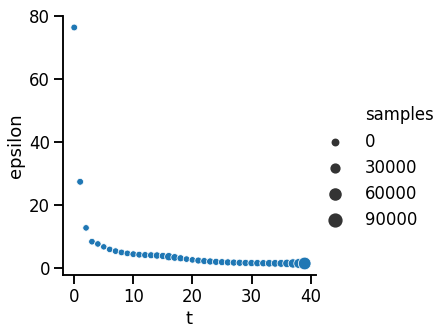

In [11]:
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
grid.savefig('results/ical/eps_evolution.pdf')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()


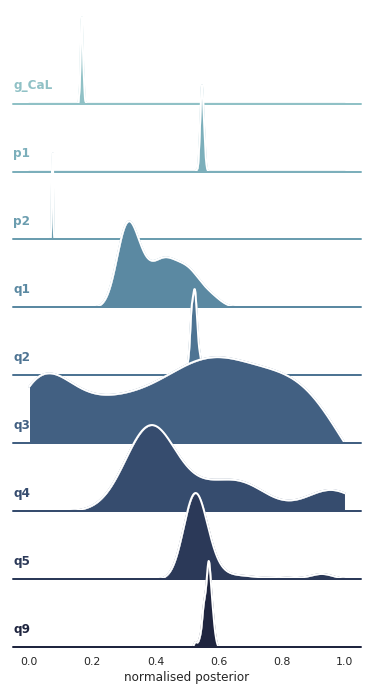

In [12]:
df, w = history.get_distribution(m=0)
g = plot_parameters_kde(df, w, limits, aspect=5, height=1.1)

# Samples for quantitative analysis

In [74]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [75]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


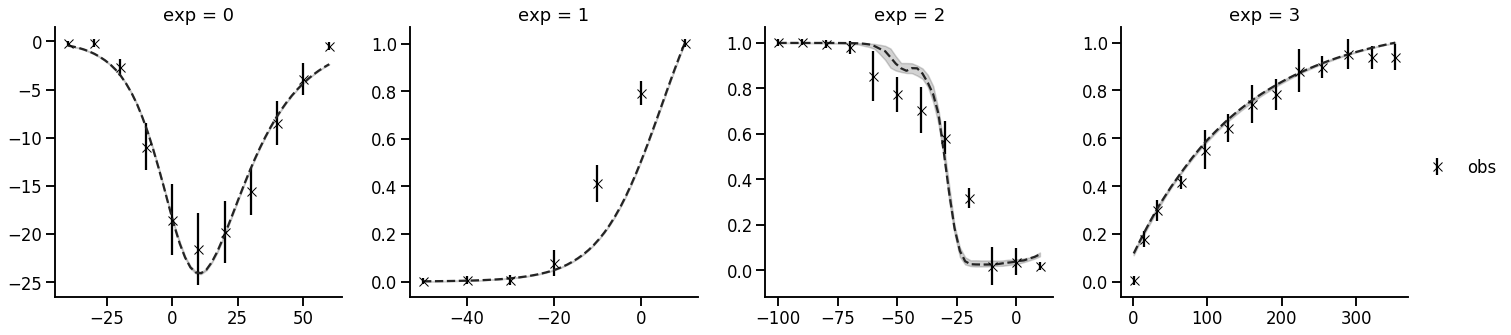

In [76]:
from ionchannelABC import plot_sim_results
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
#xlabels = ["voltage, mV", "voltage, mV", "voltage, mV"]
#ylabels = ["current density, pA/pF", "activation", "activation time constant"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)

In [20]:
# Peak current density
grouped = samples[samples['exp']==0].groupby('sample')
output = grouped.apply(min)['y']
print(output.mean())
print(output.std())

-22.80611448
0.40909766862765334


In [24]:
# Half-activation voltage and slope factor
grouped = samples[samples['exp']==1].groupby('sample')
from scipy.optimize import curve_fit
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((Vhalf-V)/Shalf))
    guess = (-10, 5)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [27]:
print(output.mean())
print(output.std())

0   -1.505816
1    5.019000
dtype: float64
0    0.174468
1    0.111882
dtype: float64


In [28]:
# Half-inactivation voltage and slope factor
grouped = samples[samples['exp']==2].groupby('sample')
from scipy.optimize import curve_fit
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((Vhalf-V)/Shalf))
    guess = (-30, -5)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [30]:
print(output.mean())
print(output.std())

0   -32.359493
1    -5.777200
dtype: float64
0    2.598134
1    2.045735
dtype: float64


In [32]:
# Recovery dynamics
grouped = samples[samples['exp']==3].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 100)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp).apply(pd.Series)

In [33]:
print(output.mean())
print(output.std())

0    112.382078
dtype: float64
0    27.927359
dtype: float64
